In [15]:
from typing import List, Tuple

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import make_pipeline
import seaborn as sns
from feature_engineering.pipe.baseline import Baseline
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = None

In [16]:
df_train = pd.read_csv("../data/train.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [18]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [19]:
df_train_copy = df_train.copy()

### Embarkedの欠損値の数は非常に小さいため、最頻値で埋めておく

In [20]:
df_train["Embarked"] = df_train["Embarked"].fillna("S")


# print(df_train["Embarked"].mode()[0])
print(df_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


### Cabinが多すぎるため接頭辞でグルーピング
- 理由として、接頭辞ごとに部屋が固まっていると考えられるため

### 種類が多すぎて多すぎてプロットできなかったCabinとSurvivedの関係を個別に見てみる

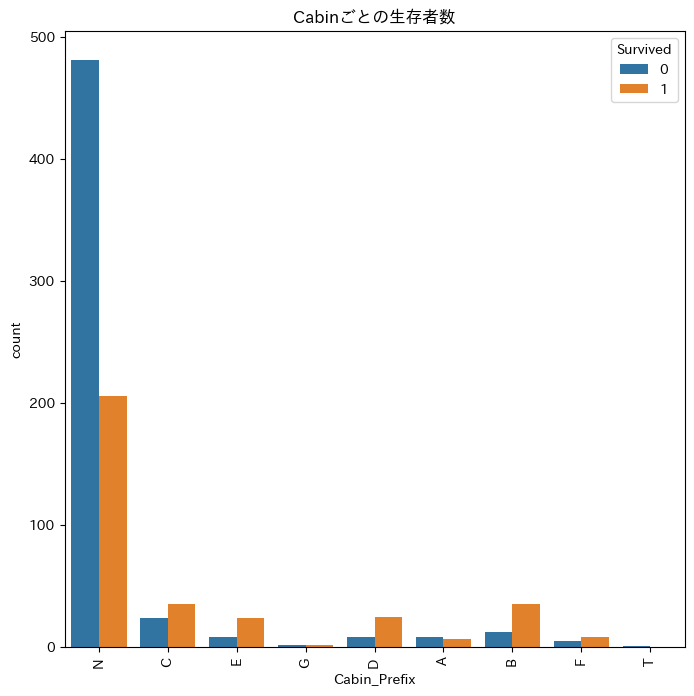

In [21]:
df_train_copy = df_train.copy()

df_train_copy["Cabin_Prefix"] = df_train_copy["Cabin"].str[0]

df_train_copy["Cabin_Prefix"] = df_train_copy["Cabin_Prefix"].fillna("N")

plt.figure(figsize=(8, 8))
sns.countplot(x="Cabin_Prefix", hue="Survived", data=df_train_copy)
plt.title("Cabinごとの生存者数")
plt.xticks(rotation=90)
plt.show()

### 種類が多すぎて多すぎてプロットできなかった Name（敬称グルーピングした） と Survived の関係を個別に見てみる


0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
        ...   
886    Officer
887       Miss
888       Miss
889         Mr
890         Mr
Name: Title, Length: 891, dtype: object


/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_79853/1366070797.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_copy["Title"].replace(


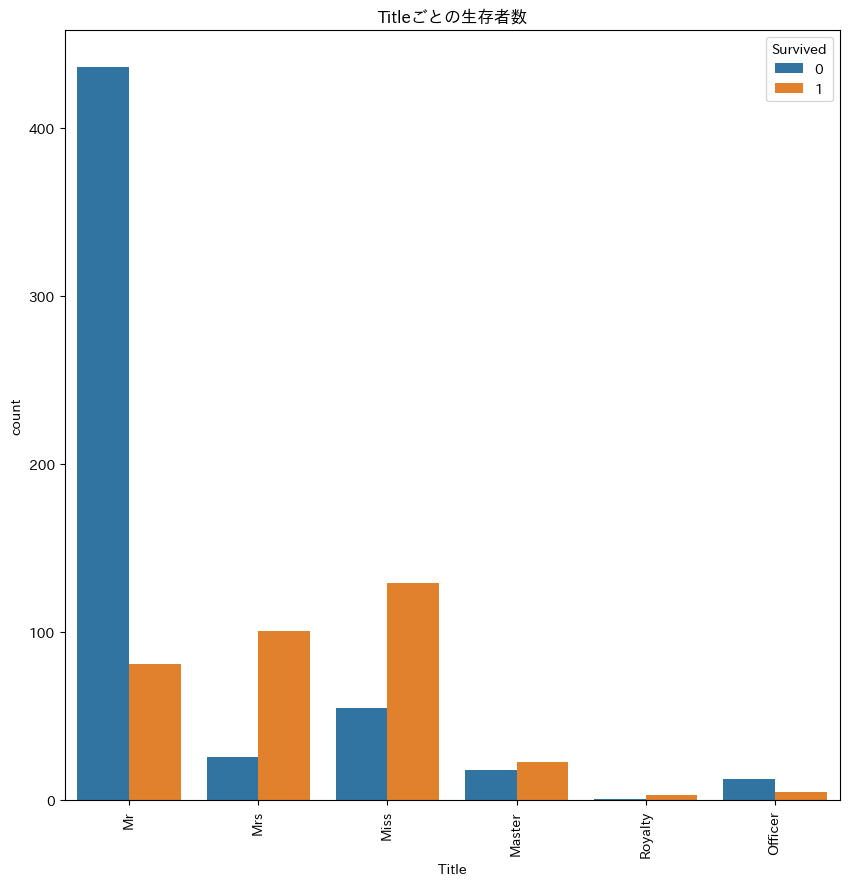

In [22]:
pattern = r"^(Mr\.|Mrs\.|Miss|Ms\.|Dr\.|Prof\.)"

df_train_copy["Title"] = df_train_copy["Name"].map(
    lambda x: x.split(", ")[1].split(". ")[0]
)
df_train_copy["Title"].replace(
    ["Capt", "Col", "Major", "Dr", "Rev"], "Officer", inplace=True
)
df_train_copy["Title"].replace(
    ["Don", "Sir", "the Countess", "Lady", "Dona"], "Royalty", inplace=True
)
df_train_copy["Title"].replace(["Mme", "Ms"], "Mrs", inplace=True)
df_train_copy["Title"].replace(["Mlle"], "Miss", inplace=True)
df_train_copy["Title"].replace(["Jonkheer"], "Master", inplace=True)

print(df_train_copy["Title"])

plt.figure(figsize=(10, 10))
sns.countplot(x="Title", hue="Survived", data=df_train_copy)
plt.title("Titleごとの生存者数")
plt.xticks(rotation=90)
plt.show()

### 相関行列をプロット

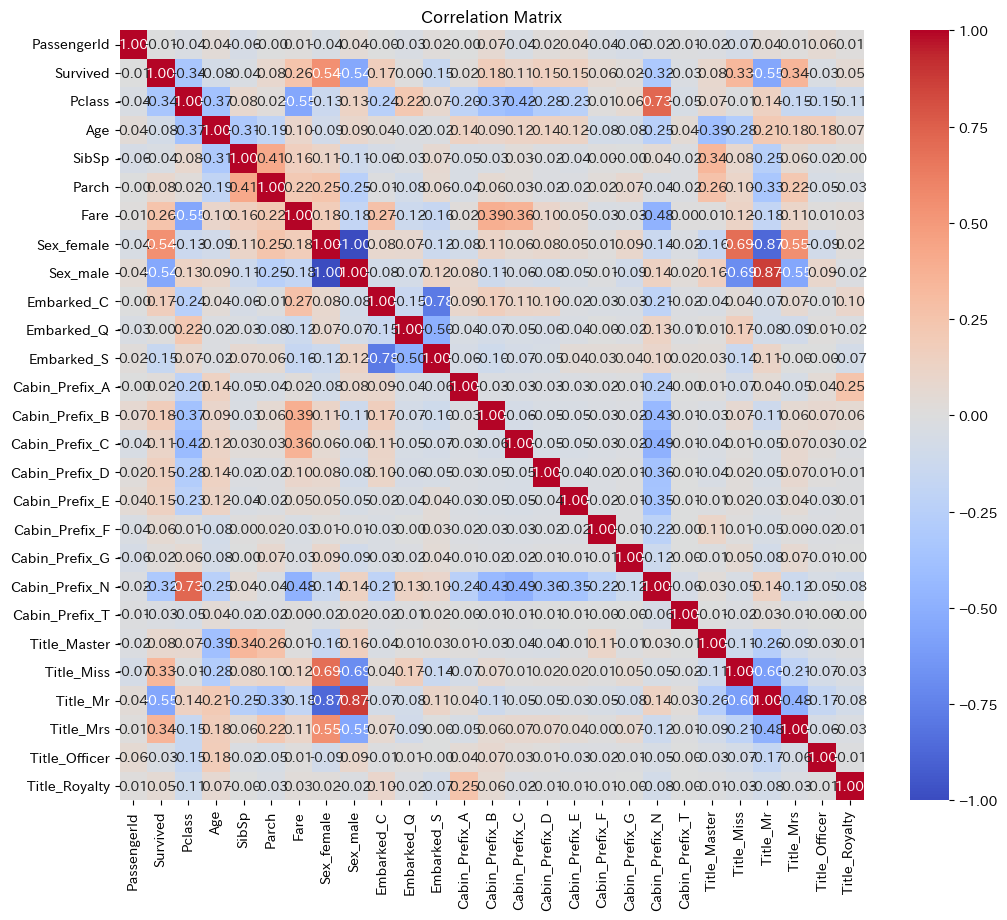

In [23]:
# 数値データのみを選択
numeric_df = df_train_copy.select_dtypes(include=["number"]).drop(
    columns=["PassengerId"]
)
categorical_df = df_train_copy.select_dtypes(exclude=["number"])

df_train_dummy = pd.get_dummies(df_train_copy.drop(columns=["Name", "Ticket", "Cabin"]))

df_train_dummy.head()

# 相関行列の計算
correlation_matrix = df_train_dummy.corr()

# 相関行列のプロット
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [24]:
df_train_copy_cabin_train = df_train_copy.dropna(subset=["Cabin"])
df_train_copy_cabin_missing = df_train_copy[df_train_copy["Cabin"].isna()]

params = {
    "learning_rate": 0.05,
    "max_depth": 10,
    "n_estimators": 100,
    "num_leaves": 31,
    "verbose": -1,
}

model = lgb.LGBMClassifier(**params)


X = df_train_copy_cabin_train[
    [
        "Fare",
        "Pclass",
    ]
]
y = df_train_copy_cabin_train["Cabin"]

model.fit(X, y)

LGBMClassifier(learning_rate=0.05, max_depth=10, verbose=-1)

## 欠損値埋めてみる
- Gが異様に増えたため多分おかしい

In [25]:
# X_missing = df_train_copy_cabin_missing[
#     [
#         "Fare",
#         "Pclass",
#     ]
# ]
# predicted_cabin = model.predict(X_missing)

# df_train_copy.loc[df_train_copy["Cabin"].isna(), "Cabin"] = predicted_cabin

In [26]:
# df_train_copy["Cabin_Prefix"] = df_train_copy["Cabin"].str[0]

# df_train_copy["Cabin_Prefix"] = df_train_copy["Cabin_Prefix"].fillna("Nan")

# plt.figure(figsize=(8, 8))
# sns.countplot(x="Cabin_Prefix", hue="Survived", data=df_train_copy)
# plt.title("Cabinごとの生存者数")
# plt.xticks(rotation=90)
# plt.show()

## Cabinの欠損をそのままにしてCabinにより精度が上がるか検証する

In [27]:
df_train_cabin_dummy = pd.get_dummies(df_train_copy, columns=["Cabin_Prefix"])

df_train_cabin_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Prefix_A,Cabin_Prefix_B,Cabin_Prefix_C,Cabin_Prefix_D,Cabin_Prefix_E,Cabin_Prefix_F,Cabin_Prefix_G,Cabin_Prefix_N,Cabin_Prefix_T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,False,False,False,False,False,False,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,False,False,True,False,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,False,False,False,False,False,False,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,False,False,True,False,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,False,False,False,False,False,False,True,False


In [28]:
bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_A"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_B"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_C"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_D"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_E"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_F"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_G"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_N"])
# bl.add_feature(feature=df_train_cabin_dummy["Cabin_Prefix_T"])


impl, score = bl.run()

print(score)
print(impl)

# bl.make_submit(test_file_path="../data/test.csv", submit_file_path="submit.csv")

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LastName"] = df["Name"].map(lambda x: x.split(",")[0])
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fare_LastName"] = df["LastName"] + "_" + df["Fare"].astype(str)
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:237: SettingWithCopyWarning:

0.7260372857949908
                    feature  importance
0                       Age       293.4
1            Cabin_Prefix_A         0.0
2            Cabin_Prefix_B         0.0
3            Cabin_Prefix_C         1.8
4            Cabin_Prefix_D         0.0
5            Cabin_Prefix_E         0.0
6            Cabin_Prefix_N        24.2
7                FamilySize        71.2
8                      Fare       487.8
9     Fare_LastName_Encoded        79.6
10                   Pclass        23.0
11  Ticket_LastName_Encoded       175.6
12             Title_Master        16.4
13               Title_Miss        26.2
14                 Title_Mr        88.2
15                Title_Mrs        43.2
16            Title_Officer         0.0


## 家族数を特徴量にしてモデルの精度向上を図る

### 女性の方が優先的に助かりそうであるため、性別を特徴量にしてみる


In [29]:
df_train_dummy_sex = pd.get_dummies(df_train_copy, columns=["Sex"])

df_train_dummy_sex.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Prefix,Title,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,N,Mr,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,True,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,N,Miss,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,C,Mrs,True,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,N,Mr,False,True


In [30]:
bl = Baseline(train_file_path="../data/train.csv")

bl.add_feature(feature=df_train_dummy_sex["Sex_female"])
# bl.add_feature(feature=df_train_dummy_sex["Sex_male"])

impl, score = bl.run()

print(score)
print(impl)

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LastName"] = df["Name"].map(lambda x: x.split(",")[0])
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fare_LastName"] = df["LastName"] + "_" + df["Fare"].astype(str)
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:237: SettingWithCopyWarning:

0.7260372857949908
                    feature  importance
0                       Age       293.4
1            Cabin_Prefix_A         0.0
2            Cabin_Prefix_B         0.0
3            Cabin_Prefix_C         1.8
4            Cabin_Prefix_D         0.0
5            Cabin_Prefix_E         0.0
6            Cabin_Prefix_N        24.2
7                FamilySize        71.2
8                      Fare       487.8
9     Fare_LastName_Encoded        79.6
10                   Pclass        23.0
11  Ticket_LastName_Encoded       175.6
12             Title_Master        16.4
13               Title_Miss        26.2
14                 Title_Mr        88.2
15                Title_Mrs        43.2
16            Title_Officer         0.0


### チケット番号が同じ=何かしらの関連性がある→チケット番号をカウントエンコーディング

In [31]:
df_train_copy["Ticket_Count"] = df_train_copy.groupby("Ticket")["Ticket"].transform(
    "count"
)

df_train_copy["Ticket_Count"]

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket_Count, Length: 891, dtype: int64

In [32]:
bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_copy["Ticket_Count"])

impl, score = bl.run()

print(score)
print(impl)

bl.make_submit(test_file_path="../data/test.csv", submit_file_path="submit.csv")

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LastName"] = df["Name"].map(lambda x: x.split(",")[0])
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fare_LastName"] = df["LastName"] + "_" + df["Fare"].astype(str)
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:237: SettingWithCopyWarning:

0.7260372857949908
                    feature  importance
0                       Age       293.4
1            Cabin_Prefix_A         0.0
2            Cabin_Prefix_B         0.0
3            Cabin_Prefix_C         1.8
4            Cabin_Prefix_D         0.0
5            Cabin_Prefix_E         0.0
6            Cabin_Prefix_N        24.2
7                FamilySize        71.2
8                      Fare       487.8
9     Fare_LastName_Encoded        79.6
10                   Pclass        23.0
11  Ticket_LastName_Encoded       175.6
12             Title_Master        16.4
13               Title_Miss        26.2
14                 Title_Mr        88.2
15                Title_Mrs        43.2
16            Title_Officer         0.0


/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:202: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Title"].replace(


KeyError: "['Fare_LastName_Encoded', 'Ticket_LastName_Encoded'] not in index"

## カテゴリ変数と生存数の関係をプロット

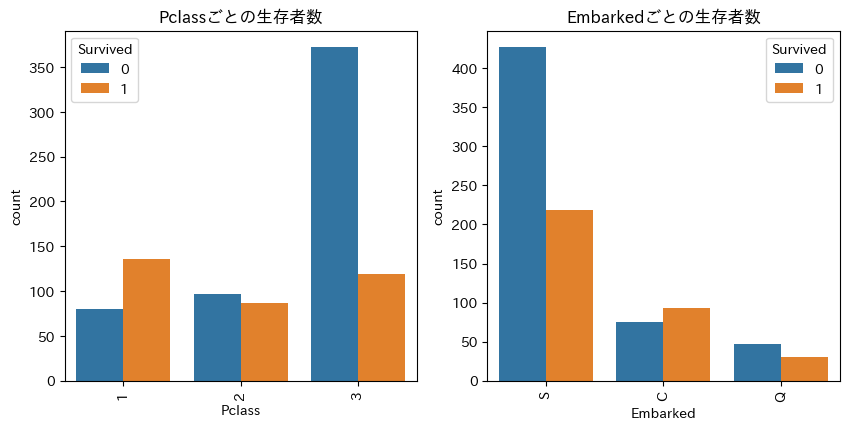

In [ ]:
categorical_columns = ["Pclass", "Embarked"]

plt.figure(figsize=(10, 10))
for i, feature in enumerate(categorical_columns):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=feature, hue="Survived", data=df_train_copy)
    plt.title(f"{feature}ごとの生存者数")
    plt.xticks(rotation=90)

In [ ]:
df_train_dummy_embarked = pd.get_dummies(df_train_copy, columns=["Embarked"])

df_train_dummy_embarked.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabin_Prefix,Title,Ticket_Count,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,N,Mr,1,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,N,Miss,1,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,C,Mrs,2,False,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,N,Mr,1,False,False,True


In [ ]:
# Embarkedに対する生存者数をカウント
df_train_copy["Embarked_Count"] = df_train_copy.groupby("Embarked")[
    "Embarked"
].transform("count")
# df_train_copy["Embarked_Count"] = df_train_copy.groupby

In [ ]:
# Embarkedごとの生存率を計算
embarked_survival_rate = df_train_copy.groupby("Embarked")["Survived"].mean()

# 生存率をデータフレームにマージ
df_train_copy = df_train_copy.merge(
    embarked_survival_rate.rename("Embarked_Survival_Rate"), on="Embarked", how="left"
)

In [ ]:
bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_dummy_embarked["Embarked_C"])
# bl.add_feature(feature=df_train_dummy_embarked["Embarked_Q"])
# bl.add_feature(feature=df_train_dummy_embarked["Embarked_S"])

bl.add_feature(feature=df_train_copy["Embarked_Survival_Rate"])
impl, score = bl.run()

print(score)
print(impl)

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:174: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Title"].replace(


0.8361496453455528
                   feature  importance
0                     Fare        1008
1                   Pclass          93
2             Title_Master          17
3               Title_Miss          55
4                 Title_Mr          76
5                Title_Mrs          68
6            Title_Officer           0
7            Title_Royalty           0
8                      Age         909
9               FamilySize         145
10          Cabin_Prefix_A           0
11          Cabin_Prefix_B           9
12          Cabin_Prefix_C          20
13          Cabin_Prefix_D          23
14          Cabin_Prefix_E          25
15          Cabin_Prefix_F           0
16          Cabin_Prefix_G           0
17          Cabin_Prefix_N          62
18  Embarked_Survival_Rate         104


## 家族かを絞る特徴量を追加してみる
- 運賃と苗字が同じだとより家族の確率が高まりそう
- チケット番号と苗字が同じ

In [ ]:
df_train_copy["LastName"] = df_train_copy["Name"].map(lambda x: x.split(",")[0])
df_train_copy["FamilySize"] = df_train_copy["SibSp"] + df_train_copy["Parch"] + 1

In [ ]:
df_train_copy["Fare_LastName"] = (
    df_train_copy["LastName"] + "_" + df_train_copy["Fare"].astype(str)
)
# df_train_copy.loc[df_train_copy["FamilySize"] == 1, "Fare_LastName"] = "Single_LastName"


df_train_copy["Ticket_LastName"] = (
    df_train_copy["LastName"] + "_" + df_train_copy["Ticket"]
)
# df_train_copy.loc[df_train_copy["FamilySize"] == 1, "Ticket_LastName"] = "Single_LastName"

200

### ターゲットエンコーディング

In [ ]:
# df_train_copy["Fare_LastName_"] =

0       27
1       48
2      171
3       71
4      171
      ... 
886    171
887    171
888    105
889    171
890    171
Name: Fare_LastName, Length: 891, dtype: int64

In [ ]:
bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_copy["Fare_LastName"])
# bl.add_feature(feature=df_train_copy["Ticket_LastName"])

impl, score = bl.run()

print(score)
print(impl)

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipe/baseline.py:174: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Title"].replace(


0.8417550687339151
           feature  importance
0             Fare        1013
1           Pclass          78
2     Title_Master          17
3       Title_Miss          73
4         Title_Mr          78
5        Title_Mrs          69
6    Title_Officer           0
7    Title_Royalty           0
8              Age        1030
9       FamilySize         151
10  Cabin_Prefix_A           0
11  Cabin_Prefix_B           9
12  Cabin_Prefix_C          29
13  Cabin_Prefix_D          21
14  Cabin_Prefix_E          28
15  Cabin_Prefix_F           0
16  Cabin_Prefix_G           0
17  Cabin_Prefix_N          60
